**Study of Quantum Field Theory systems via quantum computing techniques**

This respository has the simulation of a $2 \times 2$ lattice for the half filled Fermi-Hubbard model, as a complementary part of the report.

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 37.5 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
n_sites = 4  # 2x2 lattice
n_qubits = 2 * n_sites
n_cells = (2, 2)
U = 1
t = 1
layers = 5

In [4]:
hamiltonian = qml.spin.fermi_hubbard("square", n_cells, hopping=t, coulomb=U)

In [5]:
dev = qml.device("default.qubit", wires=n_qubits)
qml.drawer.use_style('pennylane')

**On-site interaction term**

The on-site Coulomb interaction for a given site can be written as

\begin{equation}
    e^{- \frac{i}{4} U \theta (1 - Z_i)(1 - Z_j)},
\end{equation}

where $\theta$ is a variational parameter. This term can be implemented using a sequence of three PennyLane operations: two single-qubit $Z$-rotations qml.RZ and one two-qubit Ising interaction gate qml.IsingZZ. The exponential can be expanded as:

\begin{equation}
    e^{- \frac{i}{4} U \theta (1 - Z_i)(1 - Z_j)}
    = e^{- \frac{i U \theta}{4}}
      e^{\frac{i U \theta}{4} Z_i}
      e^{\frac{i U \theta}{4} Z_j}
      e^{-\frac{i U \theta}{4} Z_i Z_j}
\end{equation}

The global phase $e^{- \frac{i U \theta}{4}}$ can be ignored. The remaining operators define the sequence of gates used in implementation.

In [6]:
def onsite_interaction(q_i,q_j,theta,U):
    qml.RZ(U * theta / 2, wires=q_i)
    qml.RZ(U * theta / 2, wires=q_j)
    qml.IsingZZ(U *  theta/ 2, wires=[q_i, q_j])

Hopping term

To implement hopping terms such as

\begin{equation}
    -\frac{t}{2} (X_0 X_4 + Y_0 Y_4) Z_1 Z_2 Z_3,
\end{equation}

where the interaction occurs between non-adjacent qubits, in this case, qubit 0 and qubit 4 in JW ordering, we must eliminate the inefficient Jordan-Wigner $Z$-string $Z_1 Z_2 Z_3$. This is accomplished by moving one qubit to an adjacent position using FSWAP gates.

 Once the qubits are adjacent, we apply a simplified hopping interaction:

\begin{equation}
    e^{- \frac{i t \theta}{4}(X_i X_j + Y_i Y_j)}.
\end{equation}

The movement and interaction can be encoded using the following algorithm:

In [7]:
def apply_hopping(q_i,q_j,theta):
    qml.IsingXY(t * theta, wires=[q_i, q_j])

def move_and_hop(i, j, theta):

    path = list(range(min(i, j), max(i, j)))

    # Mover j hacia i
    for k in path:
        qml.FermionicSWAP(phi=np.pi,wires=[k, k+1])

    # Aplicar hopping entre adyacentes
    apply_hopping(i, i+1, theta)

    # Deshacer swaps
    for k in reversed(path):
        qml.FermionicSWAP(phi=np.pi,wires=[k, k+1])


With all the functions defined we can construct a layer for the Hamiltonian Variational Asantz

In [8]:
def hva_layer(params, layer):
    p = params[layer]


    move_and_hop(0, 3, p[0])
    move_and_hop(0, 4, p[1])
    move_and_hop(1, 2, p[2])
    move_and_hop(1, 5, p[3])
    move_and_hop(3, 7, p[4])
    move_and_hop(2, 6, p[5])
    move_and_hop(4, 7, p[6])
    move_and_hop(5, 6, p[7])

    onsite_interaction(0, 1, p[8], U)
    onsite_interaction(2, 3, p[9], U)
    onsite_interaction(4, 5, p[10], U)
    onsite_interaction(6, 7, p[11], U)

All what is left is to preapre de initial state, and construct the classical optimizer.

Running VQE...
Step 0: Energy = 0.286064
Step 10: Energy = -1.623356
Step 20: Energy = -1.850896
Step 30: Energy = -2.006164
Step 40: Energy = -2.043913
Step 50: Energy = -2.051615
Step 60: Energy = -2.039839
Step 70: Energy = -2.055252
Step 80: Energy = -2.036483
Step 90: Energy = -2.040790


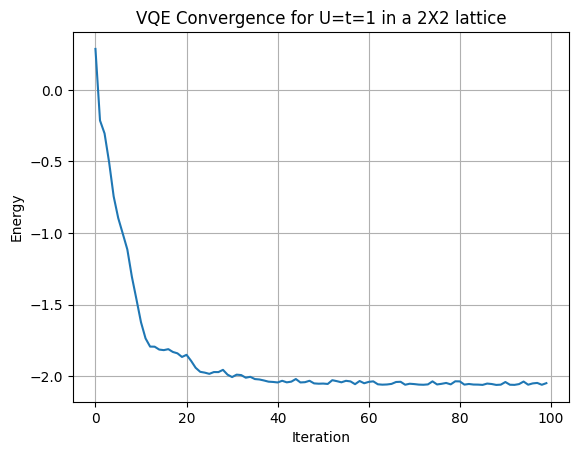


Final Optimized Circuit:


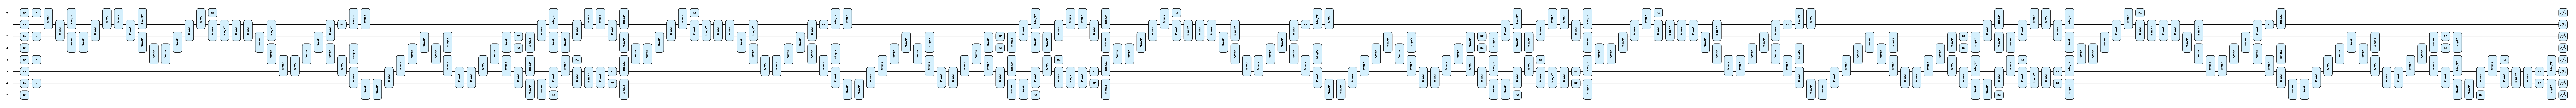

Estimated ground state energy: -2.048762


In [10]:
                                                                                                                                                                                                                                                                                                                                                                                                                                             # Prepare initial half-filled Slater determinant (2↑, 2↓)
def prepare_initial_state():
    # 0,2 (↑) and 4,6 (↓) as occupied
    for i in [0, 2, 4, 6]:
        qml.PauliX(wires=i)

# Cost circuit
def circuit(params):
    prec = 0.1
    rand_angle = np.pi + prec*np.random.rand() #noise
    for i in range(n_qubits):
        qml.RX(rand_angle, wires=i)
    prepare_initial_state()
    for l in range(layers):
        hva_layer(params, l)


@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(hamiltonian)

# Run VQE
def run_vqe(max_steps=100):
    np.random.seed(42)
    params = np.random.uniform(0, np.pi, size=(layers, 12))
    opt = qml.AdamOptimizer(stepsize=0.1)
    energies = []

    for i in range(max_steps):
        params, energy = opt.step_and_cost(cost_fn, params)
        energies.append(energy)
        if i % 10 == 0:
            print(f"Step {i}: Energy = {energy:.6f}")

    # Plot convergence
    plt.plot(energies)
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.title("VQE Convergence for U=t=1 in a 2X2 lattice")
    plt.grid()
    plt.show()

    print("\nFinal Optimized Circuit:")
    fig, ax = qml.draw_mpl(cost_fn)(params)
    plt.show()

    return energy



# Execute
print("Running VQE...")
ground_energy = run_vqe()
print(f"Estimated ground state energy: {ground_energy:.6f}")
